In [47]:
import numpy as np
import tushare as ts
import pandas as pd
from dateutil.parser import parse
from sklearn.linear_model import LinearRegression
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#中文字符和负数显示
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False

### Download data from Tushare

In [ ]:
#调用tushare数据接口
token = 'f558cbc6b24ed78c2104e209a8a8986b33ec66b7c55bcfa2f46bc108'
ts.set_token(token)
pro = ts.pro_api()

In [ ]:
def access_data(start_date, end_date, pro):
    code_list = pro.stock_basic(exchange='', list_status='L', fields='ts_code')
    code_list = code_list['ts_code'].tolist()
    result = []

    for stockid in code_list: 
        stock_data = pro.stk_factor_pro(ts_code = stockid, start_date = '20140101', end_date = '20240105', 
                           fields='ts_code, trade_date, close, turnover_rate, turnover_rate_f,volume_ratio, pe, pe_ttm, pb, ps, ps_ttm, dv_ratio, dv_ttm, total_share, float_share, free_share, total_mv,circ_mv')
        result.append(stock_data)
    result_df = pd.DataFrame(result, columns=['ts_code', 'trade_date', 'close', 'turnover_rate', 'turnover_rate_f',
                                                'volume_ratio', 'pe', 'pe_ttm', 'pb', 'ps', 'ps_ttm', 'dv_ratio',
                                               'dv_ttm', 'total_share', 'float_share', 'free_share', 'total_mv',
                                              'circ_mv'])
    
    return result_df

In [ ]:
#导入数据讲数据保存为parquet文件，parquet可用于较大数据存储，比csv文件方便
ten_years_data = access_data(start_date='20140101', end_date='20231201', pro=pro)
ten_years_data.to_parquet('ten_years.parquet')

### Import data

In [48]:
class ImportData():
    def __init__(self):
        self.stock_data = pd.read_parquet('ten_years.parquet')
        self.industry = pd.read_csv('industry.csv')

    def factor_calculation(self):
        # 把industry表格跟stock_data表格合并
        df = self.stock_data.merge(self.industry, on='ts_code', how='left')
        df['ep'] = 1 / df['pe_ttm']
        stock = df[['ts_code', 'trade_date', 'close', 'pe_ttm','industry','circ_mv']]
        # 计算ep因子
        stock['ep'] = 1/stock['pe_ttm']
        #空缺因子填充为0（参照华泰单因子研报）
        stock[['pe_ttm', 'ep']] = stock[['pe_ttm', 'ep']].fillna(value = 0, method=None, axis=None, inplace=False)

        return stock
    
    def data_output(self):
        data = self.factor_calculation()
        # 把日期从str格式改为datetime格式
        data['trade_date'] = data.trade_date.apply(str).apply(parse)
        #设定双重重索引的数据格式
        data = data.set_index(['trade_date', 'ts_code'])
        #根据第一索引排序
        data = data.sort_index()
        
        return data

In [49]:
### 最终导出的版本如下
stock_data = ImportData().data_output()
stock_data

close    pe_ttm industry       circ_mv        ep
trade_date ts_code                                                     
2014-01-02 000001.SZ   12.23    6.7462       金融  6.819328e+06  0.148232
           000002.SZ    7.99    6.4556      房地产  7.730278e+06  0.154904
           000004.SZ   11.81  299.3540     信息技术  9.905692e+04  0.003341
           000005.SZ    2.49  355.2260       工业  2.275220e+05  0.002815
           000006.SZ    4.87   10.3446      房地产  6.506091e+05  0.096669
...                      ...       ...      ...           ...       ...
2023-12-01 603444.SH  268.63   14.7903     信息技术  1.935240e+06  0.067612
           603456.SH   28.13   22.1086     医疗保健  2.526375e+06  0.045231
           603458.SH    9.08   26.7817       工业  2.826784e+05  0.037339
           603466.SH   13.08   29.6192     可选消费  7.779650e+05  0.033762
           603477.SH   33.09    0.0000     日常消费  1.674694e+06  0.000000

[7404652 rows x 5 columns]

### DataPreprocess
###### 计算出来的EP因子，需要去极值，标准化，行业市值中心化

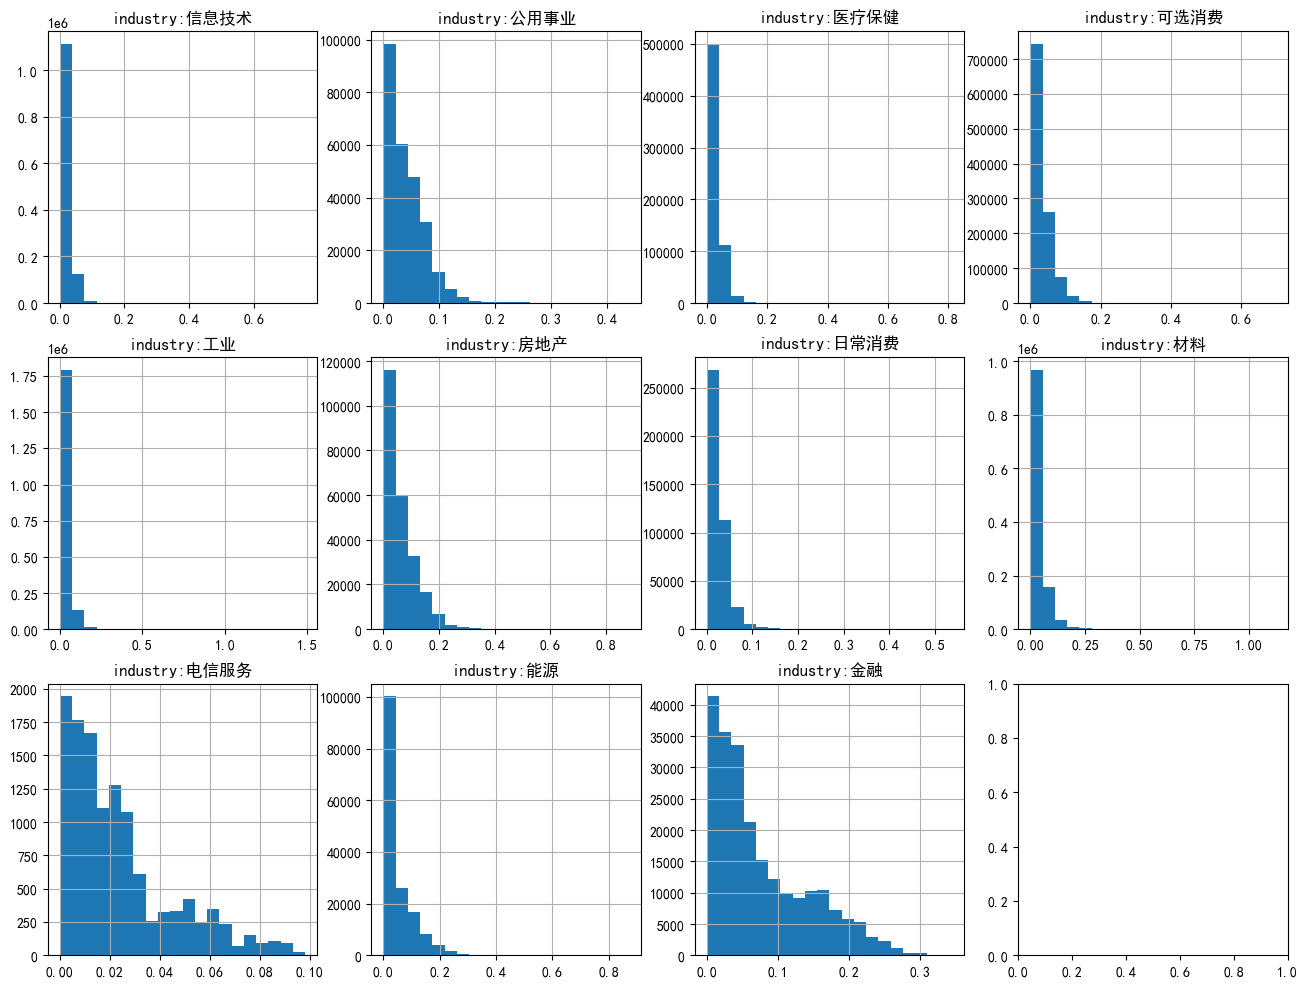

In [ ]:
###可视化观察数据分布：
# fig, axes = plt.subplot(2, 5, figsize=(15,6))

fig, axes = plt.subplots(3, 4, figsize=(16, 12)) 
axes = axes.flatten()

grouped = stock_data.reset_index().groupby('industry')

for i, (industry, group) in enumerate(grouped):
    ax = axes[i]
    group['ep'].hist(bins=20, ax=ax)
    ax.set_title(f'industry:{industry}')

plt.show()

# 图片说明不同行业的ep值数值，ep值分布有明显差异，要进行行业中心化消除因子的行业差异
# 去极值是消去极端值的影响
# 标准化是使得多个因子有可比性（一般在多因子模型里面用多个因子选股这个操作非常必要，现在我们是单因子模型，让这个流程更有完备性吧）

In [60]:
class DataPreprocess():
    def __init__(self):
        self.raw_data = stock_data
        self.factor = 'ep'

    #去极值
    def winsorize(self, data,std = 3):
        upper = data.mean() + std*data.std()
        lower = data.mean() - std*data.std()
        data[data < lower] = lower
        data[data > upper] = upper
        
        return data
    
    #标准化
    def standardize(self, data):
        x = (data - data.mean())/data.std()

        return x
    
    #行业市值中性化
    def neuturalize(self, data):
        y = data[self.factor]
        x = data.drop([self.factor],axis=1)
        lr = LinearRegression()
        lr.fit(x,y)
        y_predict = lr.predict(x)
        data[self.factor] = data[self.factor] - y_predict

        return data


    def first_step_preprocess(self):
        #去极值
        factor_winsorize = self.raw_data['ep'].groupby('trade_date').apply(self.winsorize)   
        #标准化
        factor_standardize=factor_winsorize.groupby('trade_date').apply(self.standardize)
        #因为多次groupy造成的多余的index去掉
        factor_standardize = factor_standardize.to_frame().droplevel(0).droplevel(0)
        pre_nuturalize_data = self.raw_data.copy()
        pre_nuturalize_data['ep'] = factor_standardize

        return pre_nuturalize_data
    
    def second_step_preprocess(self):
        stock_new = self.first_step_preprocess()
        #设置行业哑变量
        industry_dummy = pd.get_dummies(stock_new['industry'],drop_first=True,prefix='industry').astype('int')
        stock_new = pd.concat([stock_new, industry_dummy],axis=1)
        stock_new = stock_new.drop(['industry','close','pe_ttm'],axis=1)

        #市值中性化
        factor_neuturalize = stock_new.groupby('trade_date').apply(self.neuturalize)
        factor_neuturalize = factor_neuturalize.droplevel(0)
        
        return factor_neuturalize[self.factor]
        



In [61]:
preprocessed_factor = DataPreprocess().second_step_preprocess()

Text(0.5, 1.0, 'EP Factor Before Process')

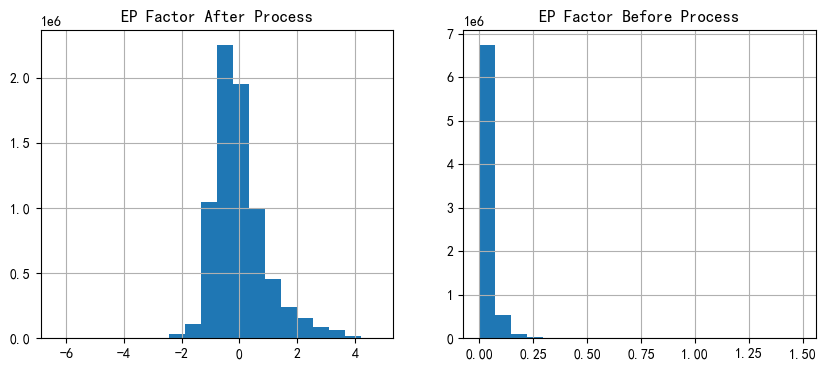

In [62]:
### 画图对比数据预处理前后
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes = axes.flatten()
preprocessed_factor.hist(bins=20, ax=axes[0])
stock_data['ep'].hist(bins=20, ax=axes[1])
axes[0].set_title('EP Factor After Process')
axes[1].set_title('EP Factor Before Process')
 

In [ ]:
### 因为行业中心化要回归，上面生成了行业哑变量，数据展示如下
pd.get_dummies(stock_data['industry'],drop_first=True,prefix='industry').astype('int')

industry_公用事业  industry_医疗保健  industry_可选消费  \
trade_date ts_code                                                  
2014-01-02 000001.SZ              0              0              0   
           000002.SZ              0              0              0   
           000004.SZ              0              0              0   
           000005.SZ              0              0              0   
           000006.SZ              0              0              0   
...                             ...            ...            ...   
2023-12-01 603444.SH              0              0              0   
           603456.SH              0              1              0   
           603458.SH              0              0              0   
           603466.SH              0              0              1   
           603477.SH              0              0              0   

                      industry_工业  industry_房地产  industry_日常消费  industry_材料  \
trade_date ts_code                                                            
2014-01-02 000001.SZ            0             0              0            0   
           000002.SZ            0             1              0            0   
           000004.SZ            0             0              0            0   
           000005.SZ            1             0              0            0   
           000006.SZ            0             1              0            0   
...                           ...           ...            ...          ...   
2023-12-01 603444.SH            0             0              0            0   
           603456.SH            0             0              0            0   
           603458.SH            1             0              0            0   
           603466.SH            0             0              0            0   
           603477.SH            0             0              1            0   

                      industry_电信服务  industry_能源  industry_金融  
trade_date ts_code                                             
2014-01-02 000001.SZ              0            0            1  
           000002.SZ              0            0            0  
           000004.SZ              0            0            0  
           000005.SZ              0            0            0  
           000006.SZ              0            0            0  
...                             ...          ...          ...  
2023-12-01 603444.SH              0            0            0  
           603456.SH              0            0            0  
           603458.SH              0            0            0  
           603466.SH              0            0            0  
           603477.SH              0            0            0  

[7404652 rows x 10 columns]

### Stock Selection Strategy

In [ ]:
### 下面是选股策略
### 在前面的数据预处理过程，是对数据groupby trade day再预处理。已经保证不同交易日不会出现overlap，因此可以直接用上面的预处理结果进行下面的选股
### 设置初始资金120000， 将股票按照ep值排序分为10组
### 每个月第一个交易日根据ep值进行选股调仓，选择每组ep排序倒数30支股票
### 假设买卖股票存在交易费用（先比较粗糙的弄了给比例）

In [64]:
#导入baseline模型，中证500
baseline = pd.read_csv('中证500.csv')
baseline['trade_date'] = baseline.trade_date.apply(str).apply(parse)
baseline.head()

,trade_date,open,high,low,close,volume
0,2014-01-02,3823.316,3848.253,3813.806,3847.879,3.080026e+09
1,2014-01-03,3841.219,3843.360,3802.992,3816.316,3.481756e+09
2,2014-01-06,3806.585,3806.585,3709.909,3710.898,3.451187e+09
3,2014-01-07,3699.901,3740.717,3688.421,3733.662,2.720862e+09
4,2014-01-08,3735.503,3768.503,3726.114,3738.205,3.194344e+09


In [65]:
class StockSelectionStrategy():
    def __init__(self):
        self.initial_cash = 12000
        self.group_num = 10
        self.portfolio_size = 30
        self.transaction_fee_buy = 0
        self.transaction_fee_sell = 0
        self.stock_data = stock_data
        self.preprocess_factor = preprocessed_factor
        self.baseline = baseline
        self.date_list = self.trade_date_list()
        self.group_stock_data = self.group_by_factor()

    def trade_date_list(self):
        datelist = stock_data.reset_index()['trade_date'].unique()
        df = pd.DataFrame(datelist, columns=['trade_date'])
        df['year'] = df['trade_date'].apply(lambda x: x.year)
        df['month'] = df['trade_date'].apply(lambda x: x.month)
        grouped = df['trade_date'].groupby([df['year'], df['month']])
        date_list = grouped.min().to_list()

        return date_list
    
    def grouped(self, data, fac_name = 'ep'):
        group_list = [i for i in range(self.group_num, 0, -1)]
        quantile_list = list(np.linspace(0, 1, num=self.group_num+1))
        ep_group = pd.qcut(data[fac_name], quantile_list, labels=group_list)
        data['group'] = ep_group

        return data

    def group_by_factor(self):
        preprocessed_stock = self.stock_data.copy()
        preprocessed_stock['ep'] = self.preprocess_factor

        preprocessed_stock = preprocessed_stock.reset_index()
        preprocessed_stock = preprocessed_stock.groupby('trade_date').apply(self.grouped)
        
        return preprocessed_stock
    
    def portfolio_each_group(self):
        date_list = self.date_list.copy()
        print('换仓日统计完毕')
        group_stock_data = self.group_stock_data.copy()
        print('ep排序分组完毕')
        cash = np.zeros((len(date_list), self.group_num))
        cash[0] = self.initial_cash
        print('初始资金设置完毕')

        # 对每个分组遍历
        for group_ind in range(1, self.group_num + 1):
            # 每组内分别对每个换仓日遍历
            date_ind = -1
            for date in date_list:
                date_ind += 1
                daily_stock = group_stock_data[group_stock_data['trade_date'] == date]
                daily_groupi = daily_stock[daily_stock['group'] == group_ind]
                daily_groupi = daily_groupi.sort_values('ep', ascending = True)

                # 第一个换仓日，直接取股
                if date_ind == 0:
                    #dropna排除close为NA，不能交易的股票
                    temp_portfolio = daily_groupi.dropna().iloc[0:self.portfolio_size, :]
                    temp_portfolio['share'] = ((self.initial_cash / self.portfolio_size) / temp_portfolio['close']) * (1 - self.transaction_fee_buy)
                    
                # 第二个换仓日往后
                else:
                    daily_stock_new = daily_stock.rename(columns={'close': 'close_new'})
                    temp_portfolio = pd.merge(left=temp_portfolio, right=daily_stock_new[['ts_code', 'close_new']], on='ts_code', how='left')
                    stock_tradable = temp_portfolio[temp_portfolio['close_new'].notnull()]
                    stock_nontradable = temp_portfolio[temp_portfolio['close_new'].isnull()]

                    # 计算该时刻投资组合的价值，考虑卖出费用
                    cash[date_ind][group_ind-1] = (stock_tradable['close_new'] * stock_tradable['share']).sum() * (1 - self.transaction_fee_sell) + (stock_nontradable['close'] * stock_nontradable['share']).sum()

                    # target_portfolio为该时刻需要构建的目标投资组合
                    target_portfolio = daily_groupi.iloc[0:self.portfolio_size, :]
                    target_portfolio = pd.merge(left=target_portfolio, right=temp_portfolio[['ts_code', 'share']], how='left')
                    # stock_to_hold表示继续持有的股票
                    stock_to_hold = target_portfolio[target_portfolio['share'].notnull()]
                    # stock_to_buy表示需要购入的股票
                    stock_to_buy = target_portfolio[target_portfolio['share'].isnull()]

                    if stock_to_hold.shape[0] == self.portfolio_size:
                        temp_portfolio = stock_to_hold
                    else:
                        # 继续持有的股票包括stock_to_hold的股票和该时刻无法交易的stock_nontradable的股票
                        stock_nontradable = stock_nontradable.drop(['close_new'], axis=1)
                        stock_to_hold = stock_to_hold._append(stock_nontradable, ignore_index=False).drop_duplicates()

                        # 需要购入的股票
                        buy_nums = self.portfolio_size - stock_to_hold.shape[0]
                        stock_to_buy = stock_to_buy.iloc[0:buy_nums, :]
                        
                        # stock_to_sell为需要换仓的股票
                        stock_to_hold['keep'] = 1
                        temp = temp_portfolio.join(stock_to_hold['keep'].to_frame())
                        stock_to_sell = temp[temp['keep'].isnull()]
                        stock_to_sell = stock_to_sell.drop(['keep'], axis=1)

                        # cash_change为换仓所得金额，考虑卖出费用
                        cash_change = (stock_to_sell['close_new'] * stock_to_sell['share']).sum() * (1 - self.transaction_fee_sell)

                        # 用cash_change购入新股票，考虑买入费用
                        stock_to_buy['share'] = ((cash_change* (1 - self.transaction_fee_buy)) / stock_to_buy.shape[0]) / stock_to_buy['close']
                        stock_to_hold = stock_to_hold.drop(['keep'], axis=1)
                        temp_portfolio = stock_to_hold._append(stock_to_buy, ignore_index=False)
            print('group', group_ind, 'calculation is finish')

        return cash
    
    def portfolio_selection(self):
        ### baseline收益情况
        portfolio_value = self.portfolio_each_group()
        baseline = self.baseline.copy()

        cash_base = np.zeros((len(self.date_list), 1))
        cash_base[0] = self.initial_cash
        date_ind = -1
        for date in self.date_list:
            date_ind += 1
            daily_data = baseline[baseline['trade_date'] == date]
            if date_ind == 0:
                share = (self.initial_cash * (1 - self.transaction_fee_buy)/ daily_data['close']).sum()
            else:
                cash_base[date_ind] = (share * daily_data['close']) * (1 - self.transaction_fee_sell)
        
        print('baseline_model calculation is finished')

        portfolio_value = pd.DataFrame(portfolio_value)
        portfolio_value['trade_date'] = pd.DataFrame(self.date_list)
        portfolio_value['000905.SH'] = pd.DataFrame(cash_base)
        portfolio_value = portfolio_value.set_index('trade_date')
        for i in range(10):
            name = 'group' + str(i+1)
            portfolio_value = portfolio_value.rename(columns={i: name})
        
        return portfolio_value
            

In [66]:
portfolio_value = StockSelectionStrategy().portfolio_selection()

换仓日统计完毕
ep排序分组完毕
初始资金设置完毕
group 1 calculation is finish
group 2 calculation is finish
group 3 calculation is finish
group 4 calculation is finish
group 5 calculation is finish
group 6 calculation is finish
group 7 calculation is finish
group 8 calculation is finish
group 9 calculation is finish
group 10 calculation is finish
baseline_model calculation is finished


### Picture

Text(0.5, 1.0, 'Group10')

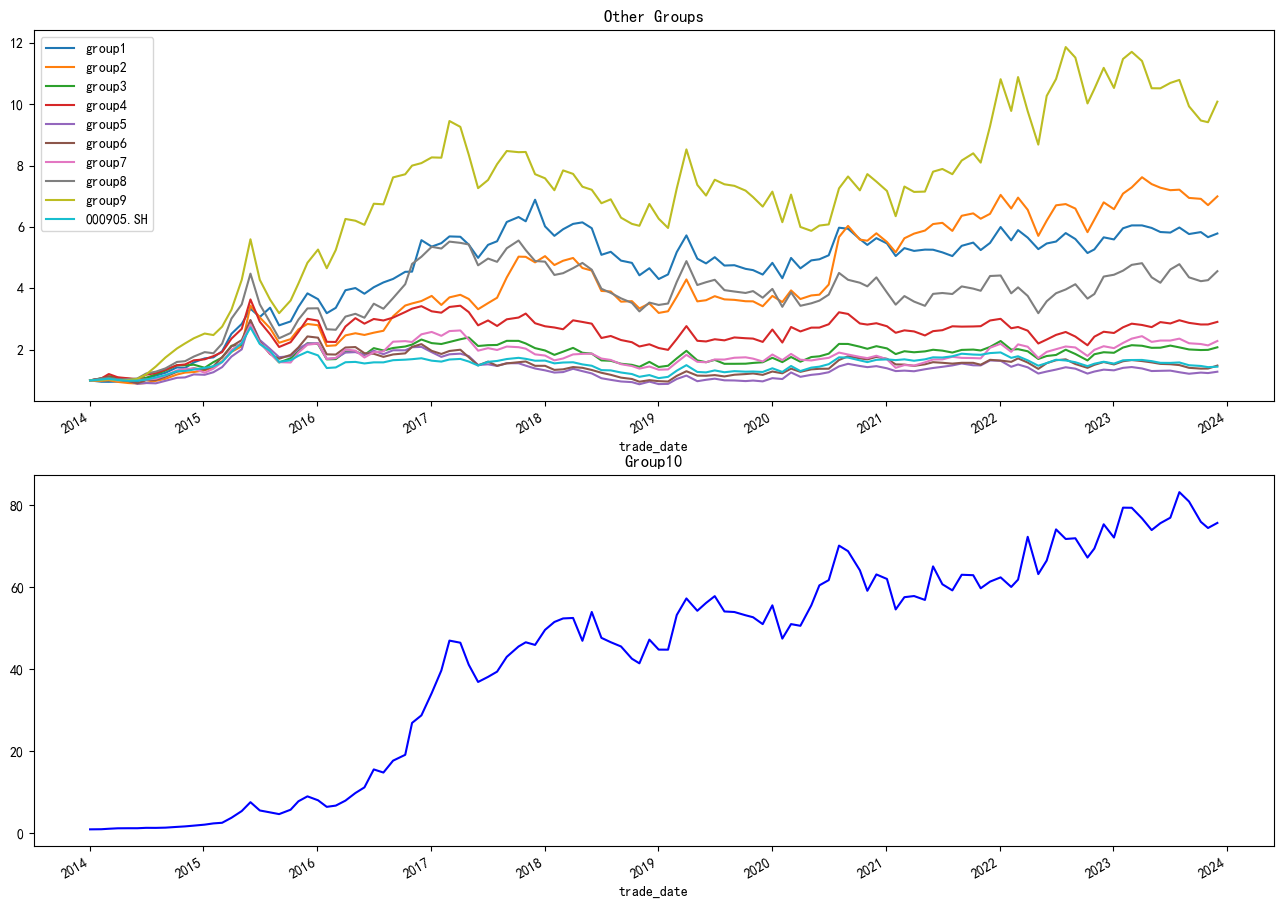

In [ ]:
#EP因子分层组合回测净值
#这个曲线相当于，2014-01-02第一个交易日的1块钱，到后面变成多少块钱。比如第10组2014年的1元钱，在2023年十二月变成了快80元，所以说收益率好
#因为group10比较高，单独拿出来画图，出现这样的结果是正常的，毕竟10年数据，可能其他更好的选股策略能干更高
#group10是ep最小那组，ep是市值的倒数，相当于投资市值最大的那一些股票
portfolio_ret = portfolio_value/portfolio_value.iloc[0]
fig, ax = plt.subplots(2, 1, figsize=(16, 12))
portfolio_ret.drop(columns=['group10']).plot(ax=ax[0])  # 绘制除group10外的组合
portfolio_ret['group10'].plot(ax=ax[1], color='blue')  # 绘制group10
ax[0].set_title('Other Groups')
ax[1].set_title('Group10')

In [68]:
### 因子IC值图像
### 计算当日因子序列和下一日收益率序列的相关系数
stock_data['ep'] = preprocessed_factor
prices = stock_data['close'].unstack()
factor_ep = stock_data['ep'].unstack()[:-1]
daily_ret = (prices/prices.shift(1) - 1)[1:]
IC = [factor_ep.iloc[i, :].dropna().corr(daily_ret.iloc[i, :].dropna()) for i in range(daily_ret.shape[0])]
date = factor_ep.reset_index()['trade_date'].to_list()

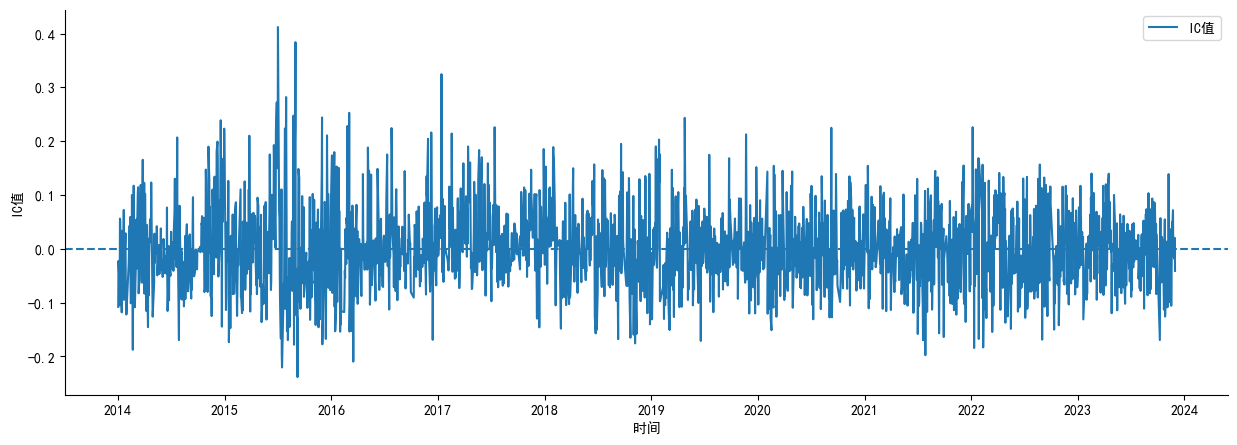

In [69]:
#IC时序图
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(15,5))
plt.xlabel('时间')
plt.ylabel('IC值')
plt.plot(date, IC, label = 'IC值')
plt.axhline(y = 0,linestyle = '--')
plt.legend()
ax=plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.show()

In [70]:
IC = np.array(IC)
print('IC序列均值：', IC.mean().round(3))
print('IC序列标准差：', IC.std().round(3))
print('IR值:', (IC.mean()/IC.std()).round(3))
print('IC小于0的比例%:', 100 * np.count_nonzero(IC < 0)/np.count_nonzero(IC))
print('|IC|大于0.05的比例%:', 100*np.count_nonzero(np.absolute(IC) > 0.05)/np.count_nonzero(IC))

IC序列均值： 0.001
IC序列标准差： 0.074
IR值: 0.007
IC小于0的比例%: 52.300041442188146
|IC|大于0.05的比例%: 46.53957728968089


In [71]:
### 计算累计收益率，年化收益率，夏普比率等指标
def indicators_calculation(portfolio_ret):
    total_ret = (portfolio_ret.iloc[-1]-1)*100
    TR = pd.DataFrame(total_ret.values, columns = ['累计收益率%'], index = total_ret.index)
    
    annual_ret=100 * (pow(1+total_ret,250/(len(baseline) - 1)) - 1)
    AR=pd.DataFrame(annual_ret.values,columns=['年化收益率%'],index=annual_ret.index)

    monthly_ret = (portfolio_value/portfolio_value.shift(1) - 1)[1:]
    annual_vol = monthly_ret.std() * np.sqrt(20) * 100
    AV = pd.DataFrame(annual_vol.values,columns=['年化波动率%'],index=annual_vol.index)


    #夏普比率
    #假设无风险收益率为年化3%
    sharpe_ratio= (AR['年化收益率%'] - 3)/AV['年化波动率%']
    SHR = pd.DataFrame(sharpe_ratio,columns = ['夏普比率'])

    return pd.concat([TR, AR, AV, SHR], axis=1, join='outer')

In [72]:
indicators_calculation(portfolio_ret=portfolio_ret)

,累计收益率%,年化收益率%,年化波动率%,夏普比率
group1,478.764909,89.569828,34.619947,2.500577
group2,599.671592,94.035861,44.907509,2.027186
group3,107.879109,62.569324,38.092886,1.563791
group4,190.687735,72.380946,41.423830,1.674904
group5,28.323395,41.909484,40.232947,0.967105
group6,48.288948,49.753890,38.734647,1.207030
group7,128.385649,65.501888,40.944431,1.526505
group8,355.874845,83.846182,43.882266,1.842343
group9,908.428408,102.555763,44.616669,2.231358
group10,7471.500561,151.948782,54.605368,2.727731


#### 